In [143]:
import scanpy as sc, scipy
import numpy as np 
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
import torch
import torch.nn as nn
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from torch import nn, optim


## Load in sc-RNAseq gene expression matrix & Metadata

In [43]:
## sc-RNAseq gene expression matrix
data = sc.read_h5ad("/Users/andyfeng/Desktop/GSE119926_RAW/output/final_data.h5ad").to_df()
data.to_csv("/Users/andyfeng/Desktop/GSE119926_RAW/output/final_data.csv")

In [42]:
data

,A1BG,A1BG-AS1,A1CF,A2M,A2M-AS1,A2ML1,A2MP1,A4GALT,A4GNT,AA06,...,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3
BCH1031-P01-A01,0.000,0.000,0.0,0.0,0.0,0.000,0.0,0.000,0.0,0.0,...,0.000,0.00,0.0,0.000,2.160,0.435,3.517,0.000,0.286,0.000
BCH1031-P01-A04,0.000,0.000,0.0,0.0,0.0,0.484,0.0,0.000,0.0,0.0,...,0.000,0.00,0.0,0.000,1.855,0.444,0.295,0.000,0.000,1.924
BCH1031-P01-A06,0.000,0.000,0.0,0.0,0.0,0.000,0.0,0.000,0.0,0.0,...,0.000,0.00,0.0,0.000,0.000,0.000,1.165,4.620,0.000,0.000
BCH1031-P01-A07,0.000,0.000,0.0,0.0,0.0,0.000,0.0,0.000,0.0,0.0,...,0.000,6.43,0.0,0.000,3.539,0.554,2.253,4.274,0.000,0.000
BCH1031-P01-A08,0.000,0.000,0.0,0.0,0.0,0.000,0.0,0.000,0.0,0.0,...,6.127,0.00,0.0,0.000,4.946,0.000,2.452,0.000,0.000,1.931
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SJ99-P04-H07,0.000,0.000,0.0,0.0,0.0,0.000,0.0,0.000,0.0,0.0,...,0.000,0.00,0.0,0.000,0.749,0.624,0.884,0.000,0.000,1.381
SJ99-P04-H08,0.000,0.000,0.0,0.0,0.0,0.000,0.0,0.000,0.0,0.0,...,0.000,0.00,0.0,2.255,0.000,0.874,0.529,0.000,0.948,0.000
SJ99-P04-H09,2.114,0.425,0.0,0.0,0.0,0.000,0.0,0.000,0.0,0.0,...,0.000,0.00,0.0,0.000,0.000,0.225,0.122,0.000,0.088,1.504
SJ99-P04-H11,0.000,0.995,0.0,0.0,0.0,0.000,0.0,0.212,0.0,0.0,...,0.000,0.00,0.0,0.000,0.000,0.000,0.000,0.000,0.424,0.000


In [90]:
## metadata of cells
cell_info = pd.read_excel('sample_info.xlsx',  header=0, skiprows=3)
cell_info = cell_info.drop('Order', axis=1)
cell_info = pd.DataFrame(cell_info)
cell_info = cell_info.set_index(cell_info.columns[0])
cell_info.index.name = None
cell_info.rename(columns={'Methylation subgroup\naccording to\nCapper et al., 2018': 'Cell Type'}, inplace=True)
cell_info

,Type,Histology,Metastasis,Gender,Age,Cells profiled,High quality cells,Malignant cells,DNA sequencing,EPIC array ID,Material,Cell Type
SJ516,Diagnostic,Classic,M+,F,9.0,576,510,507,Genome,202242420246_R07C01,FFPE,WNT
MUV44,Diagnostic,Classic,M0,M,9.0,384,303,301,Exome,202817030045_R01C01,Frozen,WNT
BCH807,Diagnostic,Classic,M+,M,12.0,384,316,307,NaN,202242420169_R05C01,FFPE,WNT
SJ99,Diagnostic,Classic,M+,M,17.0,384,338,338,Exome,201557560023_R03C01,FFPE,WNT
SJ129,Diagnostic,Classic,M0,F,17.0,384,313,313,Genome,202250800199_R06C01,FFPE,WNT
MUV41,Diagnostic,Desmoplastic/Nodular,M0,M,4.0,384,338,338,Exome,202234370067_R06C01,Frozen,SHH-infant
SJ454,Diagnostic,Desmoplastic/Nodular,M+,M,3.0,384,304,293,NaN,202817030045_R02C01,Frozen,SHH-infant
SJ577,Diagnostic,Desmoplastic/Nodular,M+,M,13.0,576,493,493,Genome,202232290166_R08C01,FFPE,SHH-adult
MUV11,Diagnostic,Large Cell/Anaplastic,M0,M,6.0,576,435,431,Exome,201490030156_R05C01,FFPE,Group 3
SJ17,Diagnostic,Large Cell/Anaplastic,M+,M,3.0,384,334,334,Exome,202250800038_R06C01,FFPE,Group 3


## Visualization

In [24]:
df_h5ad = sc.read_h5ad("/Users/andyfeng/Desktop/GSE119926_RAW/output/final_data.h5ad")
df_h5ad

AnnData object with n_obs × n_vars = 8691 × 23686
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'RNA_snn_res.0.25', 'seurat_clusters', 'RNA_snn_res.0.5', 'sample', 'subtype'

In [25]:
## visualize the data pattern using umap
sc.tl.pca(df_h5ad, n_comps=50, svd_solver='arpack')
sc.tl.tsne(df_h5ad, n_pcs=50, random_state=123)

/Users/andyfeng/anaconda3/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


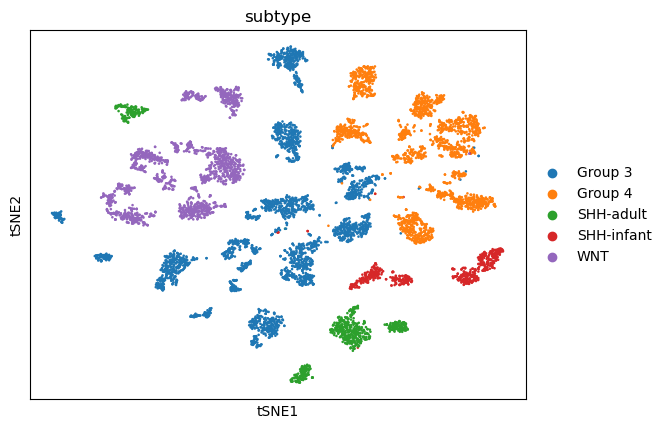

In [26]:
sc.pl.tsne(df_h5ad, color='subtype')

## Data Pre-Processing

In [99]:
## generate y
rownames = data.index.str.split('-').str[0]
y = [cell_info.loc[i]['Cell Type'] for i in rownames]
print(len(y))
y


8691


['Group 4',
 'Group 4',
 'Group 4',
 'Group 4',
 'Group 4',
 'Group 4',
 'Group 4',
 'Group 4',
 'Group 4',
 'Group 4',
 'Group 4',
 'Group 4',
 'Group 4',
 'Group 4',
 'Group 4',
 'Group 4',
 'Group 4',
 'Group 4',
 'Group 4',
 'Group 4',
 'Group 4',
 'Group 4',
 'Group 4',
 'Group 4',
 'Group 4',
 'Group 4',
 'Group 4',
 'Group 4',
 'Group 4',
 'Group 4',
 'Group 4',
 'Group 4',
 'Group 4',
 'Group 4',
 'Group 4',
 'Group 4',
 'Group 4',
 'Group 4',
 'Group 4',
 'Group 4',
 'Group 4',
 'Group 4',
 'Group 4',
 'Group 4',
 'Group 4',
 'Group 4',
 'Group 4',
 'Group 4',
 'Group 4',
 'Group 4',
 'Group 4',
 'Group 4',
 'Group 4',
 'Group 4',
 'Group 4',
 'Group 4',
 'Group 4',
 'Group 4',
 'Group 4',
 'Group 4',
 'Group 4',
 'Group 4',
 'Group 4',
 'Group 4',
 'Group 4',
 'Group 4',
 'Group 4',
 'Group 4',
 'Group 4',
 'Group 4',
 'Group 4',
 'Group 4',
 'Group 4',
 'Group 4',
 'Group 4',
 'Group 4',
 'Group 4',
 'Group 4',
 'Group 4',
 'Group 4',
 'Group 4',
 'Group 4',
 'Group 4',
 'Gr

In [102]:
## onehot encode y
encoder = OneHotEncoder()
y_reshaped = np.array(y).reshape(-1, 1)
encoder.fit(y_reshaped)
y_encoded = encoder.transform(y_reshaped)

In [150]:
y = y_encoded.toarray()
y.shape

(8691, 5)

In [112]:
X = data.values
X.shape

(8691, 23686)

In [151]:
## 60% training, 20% validation, 20% testing
Xtrain, Xbulk, ytrain, ybulk = train_test_split(X, y, test_size=0.4, random_state=7265)
Xval, Xtest, yval, ytest = train_test_split(Xbulk, ybulk, test_size=0.5, random_state=7265)

## Convolution Neural Network

In [153]:
class DeepCNN(nn.Module):
    def __init__(self):
        super(DeepCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, stride=1, padding='same')
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding='same')
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=1)
        self.fc1 = nn.Linear(32 * 30 * 30, 256)
        self.fc2 = nn.Linear(256,10)
        self.relu = nn.ReLU()
    
        
    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool1(x)
        x = self.relu(self.conv2(x))
        x = self.pool2(x)
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [155]:
kf = KFold(n_splits=6, shuffle=True, random_state=123)
accuracies = []

Xtrain = torch.tensor(Xtrain, dtype=torch.float32)
ytrain = torch.tensor(y, dtype=torch.long)



for train_index, val_index in kf.split(Xtrain):
    X_train, X_val = Xtrain[train_index], Xtrain[val_index]
    y_train, y_val = ytrain[train_index], ytrain[val_index]
    
    model = DeepCNN()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=2e-3)
    

    for epoch in range(50):  
        optimizer.zero_grad()  
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()  
        optimizer.step()  
    
    with torch.no_grad():
        outputs = model(X_val)
        _, predicted = torch.max(outputs.data, 1)
        accuracy = accuracy_score(y_val.numpy(), predicted.numpy())
        accuracies.append(accuracy)

print(f"Average Accuracy: {np.mean(accuracies):.2f}")


/var/folders/4n/b2dfcxpx2bgck0gwjjp0j_l80000gn/T/ipykernel_37682/2815239495.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Xtrain = torch.tensor(Xtrain, dtype=torch.float32)


RuntimeError: Expected 3D (unbatched) or 4D (batched) input to conv2d, but got input of size: [4345, 23686]